# Inital Data EDA
Check on data size, distribution, quality, structure

In [1]:
import json
data_path = '../data/gutenberg-paragraphs.json'
with open(data_path, 'r') as data_infile:
    data = json.load(data_infile)

# print the first and last 3 entries
print(json.dumps(data[:3]+data[-3:], indent=2))

[
  {
    "text": "\nEmma Woodhouse, handsome, clever, and rich, with a comfortable home\nand happy disposition, seemed to unite some of the best blessings\nof existence; and had lived nearly twenty-one years in the world\nwith very little to distress or vex her.",
    "austen": 1
  },
  {
    "text": "She was the youngest of the two daughters of a most affectionate,\nindulgent father; and had, in consequence of her sister's marriage,\nbeen mistress of his house from a very early period.  Her mother\nhad died too long ago for her to have more than an indistinct\nremembrance of her caresses; and her place had been supplied\nby an excellent woman as governess, who had fallen little short\nof a mother in affection.",
    "austen": 1
  },
  {
    "text": "Sixteen years had Miss Taylor been in Mr. Woodhouse's family,\nless as a governess than a friend, very fond of both daughters,\nbut particularly of Emma.  Between _them_ it was more the intimacy\nof sisters.  Even before Miss Taylor had c

In [2]:
# Set up seaborn plotting
# Seaborn is as of writing incompatible with numpy 2.X, the virtual environment needs to be downgraded to numpy==1.25
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('dark')

In [3]:
positive = [entry['text'] for entry in data if entry['austen']]
negative = [entry['text'] for entry in data if not entry['austen']]

n_p = len(positive)
n_n = len(negative)

print(f'True/False values: {n_p}/{n_n}')
print(f'% of values that are by Austen: {100*n_p/(n_n+n_p):.2f}%')

True/False values: 4749/7861
% of values that are by Austen: 37.66%


# Sentence and word length
Look at how long each entry is and consider split by flag
Cosider charachter, word, and line counts

In [4]:
# "\n" is in the above examples - how is this considered? It should just be 1 character - the new line - but if it is stored as "\"+"n" then that would double it and not encode it corectly
print(positive[0])
print(len(positive[0]))
print(len(positive[0].replace('\\n', '\n')))


Emma Woodhouse, handsome, clever, and rich, with a comfortable home
and happy disposition, seemed to unite some of the best blessings
of existence; and had lived nearly twenty-one years in the world
with very little to distress or vex her.
240
240


Encoding of new lines looks correct. However the new lines seem to be how they would be represented in print - rather than where they gramatically go. Further consideration when encoding is needed.

In [5]:
import re

# Get lengths of inputs
lengths = dict()

# Character length
lengths['char'] = {}
lengths['char'][True] = [len(t) for t in positive]
lengths['char'][False] = [len(t) for t in negative]

# Word length (words are separated by whitespace)
lengths['word'] = {}
lengths['word'][True] = [len(re.split(r'\s+', t)) for t in positive]
lengths['word'][False] = [len(re.split(r'\s+', t)) for t in negative]


# Line length (lines are separated by '\n'. As discussed above, 
# newlines are not necessarily correct)
lengths['line'] = {}
lengths['line'][True] = [len(re.split(r'\n', t)) for t in positive]
lengths['line'][False] = [len(re.split(r'\n', t)) for t in negative]

In [6]:
import numpy as np
def summary_string(lengths:list, flag:bool):
    """Generates a summary string for imput lengths.
    Summarised average, max, min lengths

    Args:
        lengths (list): lengths to consider
        flag (bool): is the flag positive?
    """
    flag_s = "positive" if flag else "negative"
    mean_len = np.mean(lengths)
    min_len = min(lengths)
    max_len = max(lengths)
    perc_99 = np.percentile(lengths, 99)

    s = f'{flag_s}: avg={mean_len:{5}.1f} min={min_len} max={max_len} 99th={perc_99:.1f}'

    return s

for metric in lengths.keys():
    print(f'Metric: {metric}')
    for flag in lengths[metric].keys():
        print(summary_string(lengths[metric][flag], flag))

Metric: char
positive: avg=421.5 min=51 max=14885 99th=1833.0
negative: avg=681.7 min=51 max=1242990 99th=1628.0
Metric: word
positive: avg= 75.3 min=2 max=2647 99th=331.6
negative: avg=120.5 min=2 max=212031 99th=286.0
Metric: line
positive: avg=  7.2 min=1 max=227 99th=30.0
negative: avg= 13.3 min=1 max=22925 99th=29.4


The Jane austen sections are, on average, considerably shorter and with lower max-lengths.
The longest value in the negatives is very long and can likely be trimmed for later analysis.

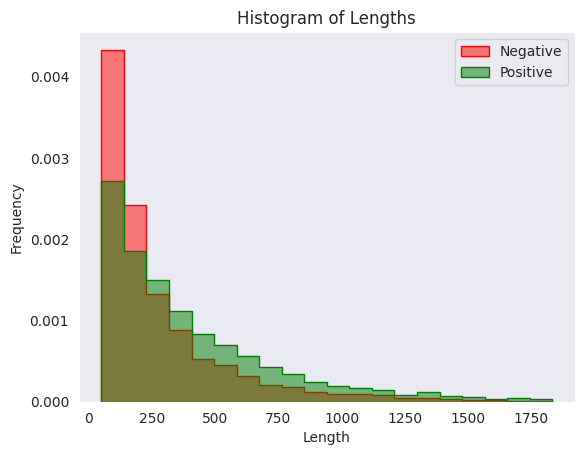

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get the lengths of positive and negative entries
positive_lengths = lengths['char'][True]
negative_lengths = lengths['char'][False]

# Calculate the 99th percentile for both positive and negative lengths
max_length = max(np.percentile(positive_lengths, 99), np.percentile(negative_lengths, 99))

pos_limited = [l for l in positive_lengths if l <= max_length]
neg_limited = [l for l in negative_lengths if l <= max_length]

# Calculate the bin edges using numpy.histogram_bin_edges
bin_edges = np.histogram_bin_edges(np.concatenate([pos_limited, neg_limited]), bins=20)

# Plot the histogram using seaborn with the same bins
sns.histplot(neg_limited, bins=bin_edges, alpha=0.5, label='Negative', stat='density', color='red', element='step')
sns.histplot(pos_limited, bins=bin_edges, alpha=0.5, label='Positive', stat='density', color='green', element='step')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Histogram of Lengths')
plt.legend()

# Show the plot
plt.show()
plt.close()

The distributions for the lower 99% actuall skew towards the Austen values being longer. The outlier may have been the cause of the discrepancy.
I will reevaluate with a cap as the max of the positive values.

In [8]:
for metric in lengths:
    max_austen = max(lengths[metric][True])
    lengths[metric][False] = [min(l, max_austen) for l in lengths[metric][False]]


for metric in lengths.keys():
    print(f'Metric: {metric}')
    for flag in lengths[metric].keys():
        print(summary_string(lengths[metric][flag], flag))

Metric: char
positive: avg=421.5 min=51 max=14885 99th=1833.0
negative: avg=310.6 min=51 max=14885 99th=1628.0
Metric: word
positive: avg= 75.3 min=2 max=2647 99th=331.6
negative: avg= 55.8 min=2 max=2647 99th=286.0
Metric: line
positive: avg=  7.2 min=1 max=227 99th=30.0
negative: avg=  5.8 min=1 max=227 99th=29.4


We now see that the average length is actually longer for the positive-flags.

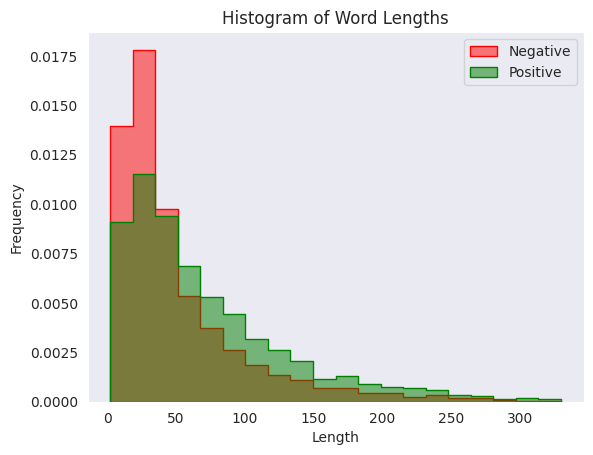

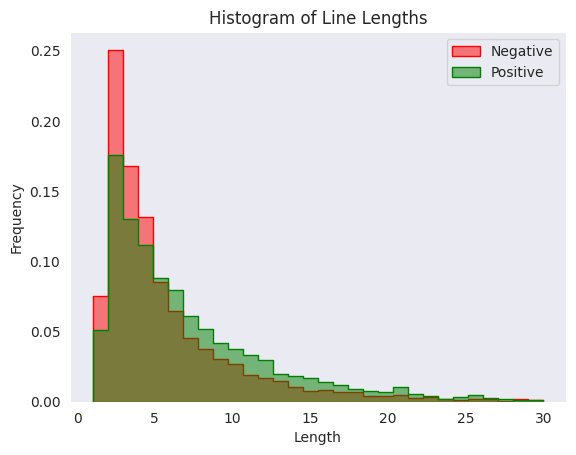

In [9]:

# Get the lengths of positive and negative entries
positive_lengths = lengths['word'][True]
negative_lengths = lengths['word'][False]

# Calculate the 99th percentile for both positive and negative lengths
max_length = max(np.percentile(positive_lengths, 99), np.percentile(negative_lengths, 99))

pos_limited = [l for l in positive_lengths if l <= max_length]
neg_limited = [l for l in negative_lengths if l <= max_length]

# Calculate the bin edges using numpy.histogram_bin_edges
bin_edges = np.histogram_bin_edges(np.concatenate([pos_limited, neg_limited]), bins=20)

# Plot the histogram using seaborn with the same bins
sns.histplot(neg_limited, bins=bin_edges, alpha=0.5, label='Negative', stat='density', color='red', element='step')
sns.histplot(pos_limited, bins=bin_edges, alpha=0.5, label='Positive', stat='density', color='green', element='step')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Histogram of Word Lengths')
plt.legend()

# Show the plot
plt.show()
plt.close()


# Get the lengths of positive and negative entries
positive_lengths = lengths['line'][True]
negative_lengths = lengths['line'][False]

# Calculate the 99th percentile for both positive and negative lengths
max_length = max(np.percentile(positive_lengths, 99), np.percentile(negative_lengths, 99))

pos_limited = [l for l in positive_lengths if l <= max_length]
neg_limited = [l for l in negative_lengths if l <= max_length]

# Calculate the bin edges using numpy.histogram_bin_edges
bin_edges = np.histogram_bin_edges(np.concatenate([pos_limited, neg_limited]), bins=int(max_length))

# Plot the histogram using seaborn with the same bins
sns.histplot(neg_limited, bins=bin_edges, alpha=0.5, label='Negative', stat='density', color='red', element='step')
sns.histplot(pos_limited, bins=bin_edges, alpha=0.5, label='Positive', stat='density', color='green', element='step')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Histogram of Line Lengths')
plt.legend()

# Show the plot
plt.show()
plt.close()

# Look at vocabulary used, frequency, and overlap

In [10]:
from collections import Counter

# Define a regular expression pattern to match alphanumeric words
# leaving in ' and - characters so it is and it's are considered different
pattern = re.compile(r'\b[\w\'-]+\b')

# Initialize a Counter to count word occurrences
word_counts_positive = Counter()
word_counts_negative = Counter()

# Tokenize the words and count their occurrences
for entry in positive:
    words = pattern.findall(entry.lower())  # Find all alphanumeric words
    word_counts_positive.update(words)


# Tokenize the words and count their occurrences
for entry in negative:
    words = pattern.findall(entry.lower())  # Find all alphanumeric words
    word_counts_negative.update(words)

In [11]:
print(f'{len(word_counts_positive)} unique words in Austen phrases')
print(f'{len(word_counts_negative)} unique words in other phrases')

12414 unique words in Austen phrases
43260 unique words in other phrases


In [12]:
print('Top 10 words in Austen\'s phrases:')
for i, (key, value) in enumerate(word_counts_positive.most_common(10)):
    print(f'{i+1:2}: "{key}" {" "*(12 - len(key))} - {value:5}')

print('\nTop 10 words in other phrases:')
for i, (key, value) in enumerate(word_counts_negative.most_common(10)):
    print(f'{i+1:2}: "{key}" {" "*(12 - len(key))} - {value:5}')

Top 10 words in Austen's phrases:
 1: "the"           - 12562
 2: "to"            - 11998
 3: "and"           - 10885
 4: "of"            - 10391
 5: "a"             -  6707
 6: "her"           -  6137
 7: "i"             -  6093
 8: "was"           -  5537
 9: "in"            -  5459
10: "it"            -  5205

Top 10 words in other phrases:
 1: "the"           - 56224
 2: "and"           - 32195
 3: "of"            - 25965
 4: "to"            - 21885
 5: "a"             - 18562
 6: "in"            - 15205
 7: "i"             - 13548
 8: "that"          - 11330
 9: "he"            - 11141
10: "it"            - 10220


These are just common English words. Let's see the top 10 words not in the other set

In [13]:
# Sort the word_counts_positive dictionary by count in descending order
sorted_word_counts_positive = sorted(word_counts_positive.items(), key=lambda item: item[1], reverse=True)
sorted_word_counts_negative = sorted(word_counts_negative.items(), key=lambda item: item[1], reverse=True)

printed = 0
print('Top 10 words ONLY in Austen\'s phrases:')
for key, value in sorted_word_counts_positive:
    if printed == 10:
        break
    if key in word_counts_negative:
        continue

    print(f'{i+1:2}: "{key}" {" "*(12 - len(key))} - {value:5}')
    printed += 1

printed = 0
print('\nTop 10 words ONLY in other phrases:')
for key, value in sorted_word_counts_negative:
    if printed == 10:
        break
    if key in word_counts_positive:
        continue

    print(f'{i+1:2}: "{key}" {" "*(12 - len(key))} - {value:5}')
    printed += 1

Top 10 words ONLY in Austen's phrases:
10: "emma"          -   763
10: "elinor"        -   600
10: "harriet"       -   409
10: "weston"        -   383
10: "knightley"     -   350
10: "elton"         -   314
10: "jane"          -   275
10: "woodhouse"     -   270
10: "elliot"        -   252
10: "dashwood"      -   227

Top 10 words ONLY in other phrases:
10: "whale"         -   981
10: "thee"          -   961
10: "o"             -   850
10: "turnbull"      -   472
10: "syme"          -   433
10: "haue"          -   430
10: "ahab"          -   429
10: "macian"        -   381
10: "alice"         -   348
10: "hath"          -   269


Understanably, the top words only in Austen's phrases relate to prominent characters.
Finally I will look at words that are in both, but more used in Austen's works

In [14]:
import pandas as pd
# Load to df and inner join on word
positive_df = pd.DataFrame(sorted_word_counts_positive, columns=['word', 'Austen Count'])
negative_df = pd.DataFrame(sorted_word_counts_negative, columns=['word', 'Other Count'])
word_df = pd.merge(positive_df, negative_df, how='inner', on='word')

# Compute metrics
word_df['Total Count'] = word_df['Austen Count'] + word_df['Other Count']

word_df

,word,Austen Count,Other Count,Total Count
0,the,12562,56224,68786
1,to,11998,21885,33883
2,and,10885,32195,43080
3,of,10391,25965,36356
4,a,6707,18562,25269
...,...,...,...,...
8814,obligations,1,3,4
8815,maxims,1,1,2
8816,constitutional,1,3,4
8817,fled,1,64,65


In [15]:
# Compute word's share

word_df['Austen Share'] = word_df['Austen Count']/word_df['Austen Count'].sum()
word_df['Other Share'] = word_df['Other Count']/word_df['Other Count'].sum()
word_df['Total Share'] = word_df['Total Count']/word_df['Total Count'].sum()

word_df

,word,Austen Count,Other Count,Total Count,Austen Share,Other Share,Total Share
0,the,12562,56224,68786,0.036274,0.069403,0.059482
1,to,11998,21885,33883,0.034646,0.027015,0.029300
2,and,10885,32195,43080,0.031432,0.039742,0.037253
3,of,10391,25965,36356,0.030005,0.032051,0.031439
4,a,6707,18562,25269,0.019367,0.022913,0.021851
...,...,...,...,...,...,...,...
8814,obligations,1,3,4,0.000003,0.000004,0.000003
8815,maxims,1,1,2,0.000003,0.000001,0.000002
8816,constitutional,1,3,4,0.000003,0.000004,0.000003
8817,fled,1,64,65,0.000003,0.000079,0.000056


In [16]:
# Compute index
word_df['Austen Index'] = word_df['Austen Share']/word_df['Total Share']
word_df['Other Index'] = word_df['Other Share']/word_df['Total Share']
word_df

,word,Austen Count,Other Count,Total Count,Austen Share,Other Share,Total Share,Austen Index,Other Index
0,the,12562,56224,68786,0.036274,0.069403,0.059482,0.609834,1.166789
1,to,11998,21885,33883,0.034646,0.027015,0.029300,1.182442,0.922009
2,and,10885,32195,43080,0.031432,0.039742,0.037253,0.843734,1.066801
3,of,10391,25965,36356,0.030005,0.032051,0.031439,0.954408,1.019490
4,a,6707,18562,25269,0.019367,0.022913,0.021851,0.886325,1.048594
...,...,...,...,...,...,...,...,...,...
8814,obligations,1,3,4,0.000003,0.000004,0.000003,0.834820,1.070611
8815,maxims,1,1,2,0.000003,0.000001,0.000002,1.669640,0.713741
8816,constitutional,1,3,4,0.000003,0.000004,0.000003,0.834820,1.070611
8817,fled,1,64,65,0.000003,0.000079,0.000056,0.051374,1.405521


In [17]:
# Get the words used much more frequently than in other values
word_df.sort_values('Austen Index', ascending=False).head(10)

,word,Austen Count,Other Count,Total Count,Austen Share,Other Share,Total Share,Austen Index,Other Index
245,willoughby,176,1,177,0.000508,0.000001,0.000153,3.320415,0.008065
342,bates,121,1,122,0.000349,0.000001,0.000105,3.311910,0.011701
347,russell,118,1,119,0.000341,0.000001,0.000103,3.311220,0.011996
583,henrietta,66,1,67,0.000191,0.000001,0.000058,3.289441,0.021306
288,smith,152,3,155,0.000439,0.000004,0.000134,3.274650,0.027629
742,marrying,47,1,48,0.000136,0.000001,0.000042,3.269713,0.029739
357,engagement,116,3,119,0.000335,0.000004,0.000103,3.255097,0.035987
200,edward,221,6,227,0.000638,0.000007,0.000196,3.251018,0.037731
915,surprize,36,1,37,0.000104,0.000001,0.000032,3.249030,0.038581
546,martin,71,2,73,0.000205,0.000002,0.000063,3.247794,0.039109


These are still heavily oriented towards names. Ley's limit it to Other Count > 10

In [18]:
word_df.loc[word_df['Other Count'] > 10].sort_values('Austen Index', ascending=False).head(10)

,word,Austen Count,Other Count,Total Count,Austen Share,Other Share,Total Share,Austen Index,Other Index
219,frank,202,11,213,0.000583,0.000014,0.000184,3.166830,0.073720
228,churchill,191,15,206,0.000552,0.000019,0.000178,3.096129,0.103943
231,acquaintance,188,18,206,0.000543,0.000022,0.000178,3.047499,0.124731
110,anne,451,47,498,0.001302,0.000058,0.000431,3.024128,0.134722
104,marianne,476,63,539,0.001375,0.000078,0.000466,2.948975,0.166849
176,feelings,248,36,284,0.000716,0.000044,0.000246,2.915992,0.180948
297,situation,144,22,166,0.000416,0.000027,0.000144,2.896726,0.189184
304,affection,138,22,160,0.000398,0.000027,0.000138,2.880130,0.196279
652,arrival,57,11,68,0.000165,0.000014,0.000059,2.799103,0.230916
493,hoped,80,16,96,0.000231,0.000020,0.000083,2.782734,0.237914


In [19]:
word_df.loc[word_df['Austen Count'] > 10].sort_values('Other Index', ascending=False).head(10)

,word,Austen Count,Other Count,Total Count,Austen Share,Other Share,Total Share,Austen Index,Other Index
2233,earth,11,633,644,0.000032,0.000781,0.000557,0.057037,1.403099
2182,black,11,410,421,0.000032,0.000506,0.000364,0.087250,1.390184
1669,white,17,627,644,0.000049,0.000774,0.000557,0.088149,1.389800
1821,heaven,15,496,511,0.000043,0.000612,0.000442,0.098022,1.385579
2128,dead,12,357,369,0.000035,0.000441,0.000319,0.108594,1.381060
1272,god,25,687,712,0.000072,0.000848,0.000616,0.117250,1.377360
1112,sea,29,749,778,0.000084,0.000925,0.000673,0.124472,1.374272
1878,water,14,359,373,0.000040,0.000443,0.000323,0.125335,1.373903
2287,show,11,217,228,0.000032,0.000268,0.000197,0.161106,1.358612
1657,dark,17,326,343,0.000049,0.000402,0.000297,0.165504,1.356732
